# Practicing & Showing workflow for crop and align DL with ROI workflow. Comments explain what each blobs of line does. Don't run workflow here, scroll down to run the actual function!

In [1]:
# import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from math import atan2, degrees
import os
from copy import deepcopy
import cv2
from time import time
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

def rotate_image_cv2(mat, angle):
    """
    Helper function used in pipeline:
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Image has to be uint8
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),	flags = cv2.INTER_NEAREST)
    return rotated_mat

In [2]:
imsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\HE1um' # 1um resolution, same size as dlsrc
dlsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um' # 1um resolution, same size as imsrc
roisrc = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_20rsf' # need to resize to imsrc/dlsrc size
xlsrc=r'\\shelter\Kyu\skin_aging\clue_cohort\CLUE_image_list_230207_v2.xlsx'

continue
2022-06-16 00.16.18
idx: 151
1 sec elapsed for overhead
section N:  1 / 2
0 sec elapsed for rotational matrix calculation
1 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
10 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
1 sec elapsed for writing images
   imID               imname  secN  \
0   151  2022-06-16 00.16.18     1   

                                                   k  degrot  d0special  \
0  [0.9586258479450883, 0.28466907744179143, -0.2...  106.54      False   

   d0Flip  
0   False  
section N:  2 / 2
0 sec elapsed for rotational matrix calculation
1 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
2 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
1 sec elapsed for writing images
   imID               imname  secN  \
0   151  2022-06-16 00.16.18     1   
1   151  2022-06-16 00.16.18     2   

                                                   k  degrot  d0special  \
0  [0.95862584

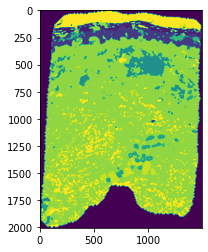

In [18]:
minTA = 20000
minTAhole = 100
minDermhole = 5000
minepisize = 1000
whitespace = 12

imdst = os.path.join(imsrc, 'kevin_imcrop_roi')
if not os.path.exists(imdst): os.mkdir(imdst)
imdst2 = os.path.join(imdst, 'kevin_imcrop_roi_10um')
if not os.path.exists(imdst2): os.mkdir(imdst2)
dldst = os.path.join(dlsrc, 'kevin_dlcrop_roi')
if not os.path.exists(dldst): os.mkdir(dldst)
dldst2 = os.path.join(dlsrc, 'kevin_dlcrop_roi_woroi')
if not os.path.exists(dldst2): os.mkdir(dldst2)

imlist = [_ for _ in os.listdir(imsrc) if _.endswith('tif')]
dllist = [_ for _ in os.listdir(dlsrc) if _.endswith('tif')]
imlist = [os.path.basename(x) for x in imlist]
dllist = [os.path.basename(x) for x in dllist]
dllist = [x.replace(".tif", "") for x in dllist]
imlist = [x.replace(".tif", "") for x in imlist]
imlist = natsorted(imlist)
dllist = natsorted(dllist)
inter = [_ for _ in imlist if _ in dllist]

xl = pd.read_excel(xlsrc)
xl = xl[xl["student score"] > 1] # filter
healthy = list(xl["path"]) #get file path, this one already has all the healthy files

healthy_list = [x for x in healthy if x.endswith(".ndpi")]
healthy_list = [os.path.basename(x) for x in healthy_list]
healthy_list = [x.replace(".ndpi", "") for x in healthy_list]
inter2 = [_ for _ in inter if _ in healthy_list] # intersection b/w imlist/dllist and healthy_list
inter2 = natsorted(inter2)
imlist = [os.path.join(imsrc, _) for _ in inter2]
dllist = [os.path.join(dlsrc, _) for _ in inter2]
imlist = [x + ".tif" for x in imlist]
dllist = [x + ".tif" for x in dllist]

if not len(imlist) == len(dllist):
    raise Exception("imlist and dllist length unequal.")

df = []
#DEBUG:
idx = 151
#idx = 74 for 2022-06-10 16.50.35
#idx = 151 for 2022-06-16 00.16.18
#idx = 35 for 2022-06-09 12.20.35
#idx = 76 for 2022-06-10 18.04.38
#idx = 138 for 2022-06-15 17.04.41

# roi_numsec = 0
start = time()
imname = imlist[idx]
dlname = dllist[idx]

imfn, ext = os.path.splitext(os.path.basename(imname))
dlfn, ext = os.path.splitext(os.path.basename(dlname))
roiname = os.path.join(roisrc, imfn+'.png')

isim = os.path.exists(os.path.join(imdst, '{}_sec{:02d}.png'.format(imfn, 1)))
isdl = os.path.exists(os.path.join(imdst, '{}_sec{:02d}.png'.format(dlfn, 1)))
if isim and isdl:
    print('continue')
    # continue
print(imfn)
print('idx:',idx)

# open image
dl = Image.open(dlname)
im = Image.open(imname)

if not im.size == dl.size:
    print("im size is",im.size)
    print("dl size is",dl.size)

    raise Exception("im and dl dimensions do not match")

TAbig = np.array(dl)


roi = np.array(Image.open(roiname))

# downsize to expedite
(width, height) = (dl.width // 10, dl.height // 10)
# dl_resized = dl.resize((width, height), resample=0)
# TA = np.array(dl_resized)
# print(TA.shape)
TA = cv2.resize(TAbig, dsize=(width,height), interpolation=cv2.INTER_NEAREST)
# print(TA.shape)
# raise
sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)  # 7sec
# define background
bw = closing(TA < whitespace, square(3))  # 12 is background
bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
bw = remove_small_holes(bw, area_threshold=minTAhole)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
sure_bg = cv2.dilate(opening, kernel, iterations=3)
# define middleground
unknown = cv2.subtract(sure_bg, sure_fg).astype('bool')

# label that background is 1 and objects are 2~N and middleground is zero -> the middleground meaning the outline of the object "unknown",
# this value is labeled 0.
# The background (black) is labeled as 1, and each object (usually four tissue in one section) is labeled from 2,3,4,5....
sure_fg_label = label(sure_fg).astype(np.int32)
sure_fg_label = sure_fg_label + 1
sure_fg_label[unknown] = 0
# perform watershed based on the marker
TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR)
label_image = cv2.watershed(TAbgr, sure_fg_label) #label_image = background one color, and the four tissues each have a color
# iterate each section
epi = (TA == 1) | (TA == 2) #epidermis
derm = (2 < TA) & (TA < whitespace) # all rest of dermis
derm = remove_small_holes(derm, area_threshold=minDermhole)
epi2 = epi & ~derm #only isolate epidermis
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2) # this returns the epidermis part of the entire image!
print(round(time() - start), 'sec elapsed for overhead')
# for numsec in range(1,numsecmax): #iterate ROI
for numsec in range(1,np.max(roi)+1):
    print('section N: ', numsec, '/', np.max(roi))
    start = time()
    roi = cv2.resize(roi, label_image.shape[::-1], interpolation=cv2.INTER_NEAREST)
    msktmp = roi == numsec

    #DEFINE TISSUE OBJECT WITHOUT ROI
    wo_roi_idx = label_image[msktmp]
    wo_roi_idx = np.median(wo_roi_idx)
    wo_roi = label_image == wo_roi_idx

    # mskderm = msktmp & derm
    mskepi = msktmp & epi2 # so this returns mskepi, which is the epidermis of the first object of the tissue. So therefore count is section N: 1/N-1.
    plt.imshow(mskepi)

    # align horizontal, mskepi (epidermis location) used to find rot. matrix
    [xt2, yt2] = np.where(mskepi)
    vertices = np.array([xt2[::10], yt2[::10]]).T
    vc = vertices - vertices.mean(axis=0)
    U, S, Vt = np.linalg.svd(vc)
    k = Vt.T
    d0 = degrees(atan2(k[1, 1], k[1, 0]))  # arctan of sin/cos in degrees
    d0special = False
    if np.linalg.det(k) < 0:
        d0special = True
        d0 = -d0
    if d0 < 0: d0 = d0 + 360
    print(round(time() - start), 'sec elapsed for rotational matrix calculation')

    start = time()
    TAtmp = deepcopy(TAbig)

    # resize and dilates the binary mask to match the size of the original image.
    mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
    kernel = np.ones((20, 20), np.uint8)
    mskbig = cv2.dilate(mskbig, kernel, iterations=3)
    TAtmp[mskbig == 0] = 0  #deeplab mask within roi

    # Rotates the original image and the binary mask using the calculated orientation.
    [xt0, yt0] = np.where(mskbig)  # mskrot is sometimes not detected
    TAtmp2 = TAtmp[np.min(xt0):np.max(xt0), np.min(yt0):np.max(yt0)] # crop mask

    mskrot = rotate_image_cv2(TAtmp2, d0)
    [xt, yt] = np.where(mskrot)  # mskrot is sometimes not detected # xt is where rotated
    print(round(time() - start), 'sec elapsed for DL rotation and cropping')

    # Flips the binary mask if the dermis part is above the epidermis part.
    start = time()
    [xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2)) #xt2 calculated to see if dermis is above epidermis
    d0Flip = False
    if np.mean(xt) - np.mean(xt2) < 0:  # if dermis is above epidermis, flip it
        d0Flip = True
        mskrot = np.rot90(np.rot90(mskrot))
        d0 += 180
    #repeat crop in case original is flipped
    [xt, yt] = np.where(mskrot)  # mskrot is sometimes not detected
    mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
    print(round(time() - start), 'sec elapsed for calculating flip')
    plt.imshow(mskrot2)
    # Multiplies the original image by the binary mask to obtain a masked image
    start = time()  # 10sec
    imtmp = np.multiply(im, np.repeat(mskbig[:, :, np.newaxis], 3, axis=2))
    imtmp2 = imtmp[np.min(xt0):np.max(xt0), np.min(yt0):np.max(yt0)]
    imrot = rotate_image_cv2(imtmp2, d0)
    print(round(time() - start), 'sec elapsed for H&E rotation')

    start = time()  # 10sec
    # Crops the rotated masked image
    imrot2 = imrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
    #apply white/gray background
    lmask = np.repeat(np.multiply(np.logical_not(imrot2[:, :, 0] > 0)[:, :, np.newaxis], 230, dtype=np.uint8),
                      3,
                      axis=2)
    imrot3 = np.add(imrot2,lmask)
    print(round(time() - start), 'sec elapsed for H&E cropping')

    mskrot2[mskrot2 == 0] = whitespace

    # repeat with woroi
    # fresh load DLmask of WSI
    TAtmp = deepcopy(TAbig)
    # load mask to select a section in WSI
    mskbig = cv2.resize(wo_roi.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
    kernel = np.ones((20, 20), np.uint8)
    mskbig = cv2.dilate(mskbig, kernel, iterations=3)
    TAtmp[mskbig == 0] = 0  # deeplab mask within roi
    #tight-crop wo_roi
    [xt0, yt0] = np.where(mskbig)
    TAtmp2 = TAtmp[np.min(xt0):np.max(xt0), np.min(yt0):np.max(yt0)]
    #rotate
    mskrot = rotate_image_cv2(TAtmp2, d0)
    #tight-crop rotated wo_roi
    [xt, yt] = np.where(mskrot)
    mskrot3 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]

    start = time()  # 10sec
    # save mask, masked image, and downsized masked image by 10.
    Image.fromarray(mskrot2.astype('int8')).save(
        os.path.join(dldst, '{}_sec{:02d}.png'.format(dlfn, numsec)))

    Image.fromarray(mskrot3.astype('int8')).save(
        os.path.join(dldst2, '{}_sec{:02d}.png'.format(dlfn, numsec)))

    Image.fromarray(imrot3.astype('uint8')).save(
        os.path.join(imdst, '{}_sec{:02d}.png'.format(imfn, numsec)))

    Image.fromarray(imrot3.astype('uint8')).resize([_ // 10 for _ in imrot3.shape][:2][::-1], resample=1).save(
        os.path.join(imdst2, '{}_sec{:02d}.png'.format(dlfn, numsec)))
    print(round(time() - start), 'sec elapsed for writing images')


    df.append({'imID': idx, 'imname': imfn, 'secN': numsec, 'k': k.flatten(), 'degrot': round(d0, 2), 'd0special':d0special, 'd0Flip':d0Flip})
    df2 = pd.DataFrame(df)
    print(df2)

# Now run the actual function:

In [1]:
# import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from math import atan2, degrees
import os
from copy import deepcopy
import cv2
from time import time
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

def rotate_image_cv2(mat, angle):
    """
    Helper function used in pipeline:
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Image has to be uint8
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),	flags = cv2.INTER_NEAREST)
    return rotated_mat

In [2]:
from crop_align_DL_withROI_edit import crop_align_DL

In [ ]:
crop_align_DL(imsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\HE1um', # 1um resolution, same size as dlsrc
dlsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um', # 1um resolution, same size as imsrc
roisrc = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_v2_021723',xlsrc=r'\\shelter\Kyu\skin_aging\clue_cohort\CLUE_image_list_230207_v2.xlsx')

2022-06-07 13.18.40
idx: 0
2 sec elapsed for overhead
section N:  1 / 1
0 sec elapsed for rotational matrix calculation
2 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
18 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
4 sec elapsed for writing images
2022-06-07 13.29.45
idx: 1
5 sec elapsed for overhead
section N:  1 / 4
0 sec elapsed for rotational matrix calculation
5 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
43 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  2 / 4
0 sec elapsed for rotational matrix calculation
5 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
7 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  3 / 4
0 sec elapsed for rotational matrix calculation
5 sec elapsed for DL rotation and cropping
1 sec elapsed for calculating flip
7 sec elapsed for H&E rotatio

C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\crop_align_DL_withROI_edit.py:173: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\Kevin\.conda\envs\wsi_analysis1\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
9 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
6 sec elapsed for writing images
2022-06-07 14.39.32
idx: 7
2 sec elapsed for overhead
section N:  1 / 3
0 sec elapsed for rotational matrix calculation
3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
21 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  2 / 3
0 sec elapsed for rotational matrix calculation
3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
4 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  3 / 3
0 sec elapsed for rotational matrix calculation
3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
3 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
2022-06-07 14.56.13
idx: 8
2 sec elapsed for overhead
s

C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\crop_align_DL_withROI_edit.py:173: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\Kevin\.conda\envs\wsi_analysis1\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
4 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
2 sec elapsed for writing images
2022-06-10 18.00.26
idx: 75
2 sec elapsed for overhead
section N:  1 / 1
0 sec elapsed for rotational matrix calculation
2 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
16 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
2022-06-10 18.04.38
idx: 76
3 sec elapsed for overhead
section N:  1 / 3
0 sec elapsed for rotational matrix calculation


C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\crop_align_DL_withROI_edit.py:173: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\Kevin\.conda\envs\wsi_analysis1\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
21 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  2 / 3
0 sec elapsed for rotational matrix calculation
3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
4 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  3 / 3
0 sec elapsed for rotational matrix calculation


C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\crop_align_DL_withROI_edit.py:173: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\Kevin\.conda\envs\wsi_analysis1\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
4 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
1 sec elapsed for writing images
2022-06-10 18.30.09
idx: 77
2 sec elapsed for overhead
section N:  1 / 4
0 sec elapsed for rotational matrix calculation
2 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
20 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
1 sec elapsed for writing images
section N:  2 / 4
0 sec elapsed for rotational matrix calculation
2 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
3 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
1 sec elapsed for writing images
section N:  3 / 4
0 sec elapsed for rotational matrix calculation
3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
3 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
1 sec elapsed for writing images
section N:  4 / 4
0 sec elapsed for rotational matrix 

C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\crop_align_DL_withROI_edit.py:173: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\Kevin\.conda\envs\wsi_analysis1\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
1 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
2 sec elapsed for writing images
2022-06-14 16.15.36
idx: 127
1 sec elapsed for overhead
section N:  1 / 1
0 sec elapsed for rotational matrix calculation
1 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
8 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
2022-06-14 16.29.21
idx: 128
2 sec elapsed for overhead
section N:  1 / 1
0 sec elapsed for rotational matrix calculation
3 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
22 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
5 sec elapsed for writing images
2022-06-14 16.54.45
idx: 129
2 sec elapsed for overhead
section N:  1 / 1
0 sec elapsed for rotational matrix calculation
2 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
18 sec elapsed for H&E rotation
0 se

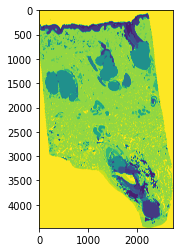

In [7]:
# then for two cases where the image isn't flipped properly (manually found), edit the d0 value and rotate the image properly and resave:
img1 = Image.open(r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\kevin_dlcrop_roi\2022-06-08 16.52.37_sec01.png')
img1 = np.array(img1)
rotimg1 = rotate_image_cv2(img1,180) # -> updated degrot in CLUE_rotation_LUT.xlsx
plt.imshow(rotimg1)
Image.fromarray(rotimg1).save(r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\kevin_dlcrop_roi\2022-06-08 16.52.37_sec01.png')

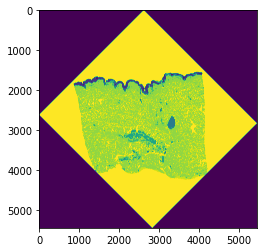

In [17]:
# img2 = Image.open(r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\kevin_dlcrop_roi\2022-06-10 16.50.35_sec01.png')
# img2 = np.array(img2)
# rotimg2 = rotate_image_cv2(img2,315)
# plt.imshow(rotimg2)
# Image.fromarray(rotimg2).save(r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\kevin_dlcrop_roi\2022-06-10 16.50.35_sec02.png')

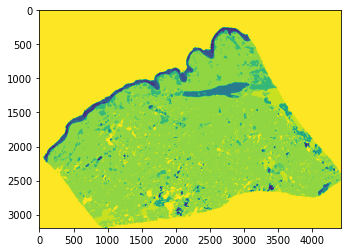

In [21]:
img3 = Image.open(r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\kevin_dlcrop_roi\2022-06-10 18.04.38_sec01.png')
img3 = np.array(img3)

rotimg3 = rotate_image_cv2(img3,90)  # -> updated degrot in CLUE_rotation_LUT.xlsx
plt.imshow(rotimg3)
Image.fromarray(rotimg3).save(r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\kevin_dlcrop_roi\2022-06-10 18.04.38_sec01.png')